<a href="https://colab.research.google.com/github/jodejetalo99/Datos-Masivos/blob/master/Mini_Proyecto3_DM2_JJTL_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Universidad Nacional Autónoma de México
# Instituto de Investigaciones en Matemáticas Aplicadas y en Sistemas
# Datos Masivos II
# José de Jesús Tapia López
# Mini-proyecto3: Usar el algoritmo de Page Rank para calcular la relevancia de los nodos a partir de la relevancia de los enlaces entrantes.
# 01 de Diciembre del 2020

## Objetivo del mini-proyecto: 
Usando el algoritmo de Page Rank y la base de datos que se te fue asignada, calcula la relevancia de los nodos a partir de la relevancia de los enlaces entrantes.

## Descripción de los datos

http://networkrepository.com/soc-twitter-follows-mun.php

Este conjunto de datos es la red dirigida que contiene información sobre quién sigue a quién en Twitter. Los nodos representan a los usuarios y un borde muestra que el usuario de la izquierda sigue al de la derecha.

## Política de agradecimientos y citas
Nos piden, de favor, citar lo siguiente si usamos los datos:

    @inproceedings{nr-aaai15,
         title = {The Network Data Repository with Interactive Graph Analytics and Visualization},
         author={Ryan A. Rossi and Nesreen K. Ahmed},
         booktitle = {AAAI},
         url={http://networkrepository.com},
         year={2015}
      }

In [ ]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, lil_matrix
from google.colab import drive
from matplotlib import pyplot as plt

drive.mount('/content/drive')

Mounted at /content/drive


## Pre-procesamiento

Convertimos el archivo .edges a un txt

In [ ]:
# leemos el txt, de tal forma que el delimitador sea por espacios en blanco
df = pd.read_csv("drive/My Drive/soc-twitter-follows-mun.txt", sep = " ")
# Nombramos las columnas para que sepamos que los usuarios de la columnas de la 
# izquierda siguen a los usuarios de las columnas de la derecha
df.columns = ["Sigue","Seguido"]
df.head()

,Sigue,Seguido
0,1,3
1,1,4
2,1,5
3,1,6
4,1,7


In [ ]:
print("La dimensión de los datos es de: ", df.shape)

La dimensión de los datos es de:  (835422, 2)


In [ ]:
# esos indices los ocupamos para ver al usuario con mayor indice en ambas columnas
# esto no necesariamente debe coincidir con el número de valores únicos
# en cada columna, porque pasar, por ejemplo, que si el usuario 2 no es seguido por nadie,
# no aparece en la segunda columna
id2_max = max(df["Seguido"])
print("El id hasta donde acaban los usuarios que son seguidos por alguien es: ", id2_max)
# lo mismo que acabo de explicar ocurre con la primera columna
id_max = max(df["Sigue"])
print("El id hasta donde acaban los usuarios que siguen a alguien es: ", id_max)

El id hasta donde acaban los usuarios que son seguidos por alguien es:  465017
El id hasta donde acaban los usuarios que siguen a alguien es:  354764


In [ ]:
print("La cantidad de usuarios distintos que siguen a alguien es de: ", len(np.unique(df['Sigue'])))
print("La cantidad de usuarios distintos que siguen a alguien es de: ", len(np.unique(df['Seguido'])))

La cantidad de usuarios distintos que siguen a alguien es de:  2502
La cantidad de usuarios distintos que siguen a alguien es de:  465015


De las dos celdas anteriores vemos que hay "huecos", es decir, hay valores que no están tanto en el conjunto {1,2,3,4,...,465017} como en el conjunto {1,2,3,...,354764}. Por lo tanto, la dimensión de la matriz que posteriormente vamos a crear, va a ser 465017x465017 para prevenir el no considerar a algunos usuarios.

Del valor de *len(np.unique(df['Sigue'])* podemos ver que habrá muchos callejones sin salida. Aprovechamos también para ver que la matriz que próximamente crearemos va a ser dispera. Esto se debe a que **la relevancia del j-ésimo usuario es la suma de los votos de los vínculos entrantes**, es decir, de las 465017 columnas de la próxima matriz, solamente 2502 van a tener valores en algunos de sus renglones.

A continuación, pretendía visualizar los nodos, pero son demasiados, se tarda mucho. En la página donde se obtienen los datos se muestran las relaciones

In [ ]:
"""
import networkx as nx

# Creamos un grafo dirigido con networkx para visualizar el árbol

# Generamos el grafo dirigido D
G = nx.DiGraph()

for i in range(1,465017+1):
  # Insertamos el nodo vacío
   G.add_node(i)


plt.figure(figsize=(30,30))
plt.title('Page Rank')
#pos=graphviz_layout(G, prog='dot')
nx.draw(G)
"""

"\nimport networkx as nx\n\n# Creamos un grafo dirigido con networkx para visualizar el árbol\n\n# Generamos el grafo dirigido D\nG = nx.DiGraph()\n\nfor i in range(1,465017+1):\n  # Insertamos el nodo vacío\n   G.add_node(i)\n\n\nplt.figure(figsize=(30,30))\nplt.title('Page Rank')\n#pos=graphviz_layout(G, prog='dot')\nnx.draw(G)\n"

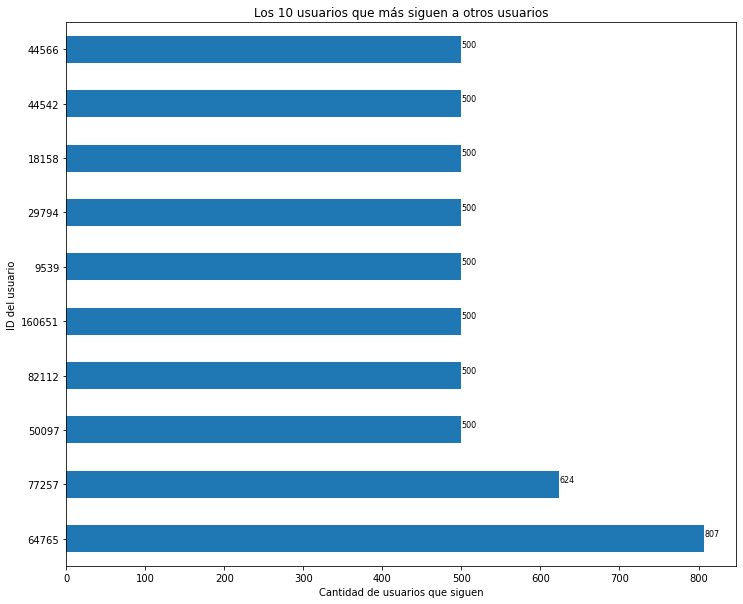

In [ ]:
# contamos el número de usuarios a los que sigue cada usuario (agrupamos a los de la primera columna)
# y los ordenamos descendentemente
frecuencia_vinculos = df.groupby("Sigue")["Seguido"].count().sort_values(ascending=False)
# obtenemos los primeros 10 que siguen a más usuarios
frecuencia_vinculos_10 = frecuencia_vinculos[0:10]
plt.figure(figsize=(12,10))
ax = frecuencia_vinculos_10.plot(kind = 'barh')
ax.set_title("Los 10 usuarios que más siguen a otros usuarios")
ax.set_ylabel("ID del usuario")
ax.set_xlabel("Cantidad de usuarios que siguen")
for i in ax.patches:
    ax.text(i.get_width()+.09, i.get_y()+.3, str(round((i.get_width()), 1)), fontsize=8)

La agrupación anterior nos indica a cuántos usuarios sigue cada usuario. Vemos que el usuario que más sigue es el 64765, pues sigue a 807 usuarios.

Es importante mencionar que hay muchos usuarios que siguen exactamente a 500 usuarios, pero en la gráfica solo mostramos unos 8 de esos.

Podemos obtener lo inverso, es decir, obtener la cantidad de seguidores de cada usuario de manera descendente:


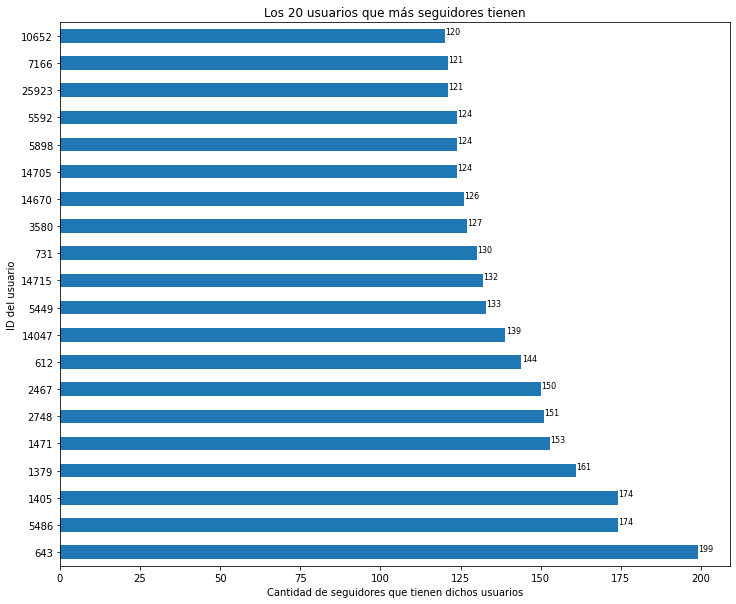

In [ ]:
# contamos el número de seguidores de cada usuario (agrupamos a los de la segunda columna)
# y los ordenamos descendentemente
seguidores_usuarios = df.groupby("Seguido")["Sigue"].count().sort_values(ascending=False)
# obtenemos los primeros 10 que más seguidores tienen
seguidores_usuarios_10 = seguidores_usuarios[0:20]
plt.figure(figsize=(12,10))
ax2 = seguidores_usuarios_10.plot(kind = 'barh')
ax2.set_title("Los 20 usuarios que más seguidores tienen")
ax2.set_xlabel("Cantidad de seguidores que tienen dichos usuarios")
ax2.set_ylabel("ID del usuario")
for i in ax2.patches:
    ax2.text(i.get_width()+.09, i.get_y()+.3, str(round((i.get_width()), 1)), fontsize=8)

De la gráfica anterior podemos observar que el usuario 643 es el que más seguidores tiene, con 199.



Ahora bien, recordemos que queremos calcular la relevancia de los nodos a partir de la relevancia de los enlaces entrantes, por lo que usaremos el algoritmo de PageRank.

PageRank calcula la relevancia de un conjunto de páginas (nodos, que en este caso son los usuarios) a partir de la relevancia de los vínculos entrantes. La formulación básica es la siguiente: 
$$ \mathbf{r}^{(t+1)} = \mathbf{M} \cdot \mathbf{r}^{(t)} $$

donde $\mathbf{M}$ es una matriz columna estocástica: $\sum_{i=1}^n r_i = 1$. El cálculo de PageRank es iterativo.

Dado que la matriz que usaremos es de una dimensión muy grande, usaremos *lil_matrix* de la biblioteca scipy.sparse.

Según la documentación, *lil_matrix* es una lista basada en filas de listas de matriz dispersa. Esta es una estructura para construir matrices dispersas de forma incremental. Insertar un solo elemento puede llevar un tiempo lineal en el peor de los casos; para construir una matriz de manera eficiente, nos debemos asegurar que los elementos estén preordenados por índice, por fila.

Entonces, como debemos ordenar los datos por filas para ser más eficiente al llenarla, lo haremos de esa forma. En este caso la suma que daría 1 sería por renglón, pero como en PageRank la suma es por columna, lo solucionamos para que sea la suma igual a 1 por columna obteniendo su tranpuesta.

In [ ]:
# creamos una matriz cuadrada de dimensión 465017
matriz_pr = lil_matrix((id2_max , id2_max))


In [ ]:
# Convertimos el dataframe del principio a una lista de renglones, i.e., lista of listas, donde
# la primera entrada es quien sigue, la segunda entrada es el seguido
lista_de_renglones = df.to_numpy().tolist()

In [ ]:
from time import time
t = time()

# colocamos un uno a la matriz en caso de que existe la relación  i -> j, es decir,
# aquella en la que el usuario i sigue al usuario j
for k in range(len(lista_de_renglones)):
  # aquí restamos un 1 al índice porque la matriz empieza desde el índice 0
  # pero los id's de los usuarios empiezan desde el índice 1
  matriz_pr[lista_de_renglones[k][0]-1, lista_de_renglones[k][1]-1] = 1.

print("Llenar la matriz tardó {} segundos ".format(time()-t))

Llenar la matriz tardó 2.7324655055999756 segundos 


In [ ]:
# por ejemplo, mostramos que sí haya un uno en el renglón 0 (usuario 1), columna 2 (usuario 3), 
# es decir, el usuario 1 sigue al usuario 3
print(matriz_pr[0,2])
# mostramos que haya un cero en el renglón 0 (usuario 1), columna 1 (usuario 2)
# es decir, el usuario 1 NO sigue al usuario 2
print(matriz_pr[0,1])

1.0
0.0


A continuación, creamos una copia de la matriz anterior. Esto lo había hecho pues tenía la intención de resolver lo de los callejones sin salida, de tal manera que los usuarios que no seguían a nadie (que en total, la cantidad de  esos usuarios es de: 465017 - 2502 = 462515), les asignáramos la misma probabilidad. Por ejemplo, el usuario 2 no sigue a nadie, pero resolviendo esto, quería hacer que en lugar de que tuviera ceros la columna de ese usuario, ponerle a cada renglón de dicha columna un 1/465017, para que tuviera la misma probabilidad de seguir a cualquier
otro usuario. No pude hacer esto porque me marcaba el error de que la memoria RAM se me acababa.

Sin embargo, no todo está perdido, pues próximamente veremos que el algoritmo de page rank escalable resuelve esta situación de los callejones sin salidas.

In [ ]:
matriz_pr_css = matriz_pr.copy()

# vamos a iterar por todas las columnas de la matriz
# si el id del usuario i aparece en la primera columna del dataframe, obtenemos la cantidad
# de usuarios que sigue ese usuario, para dividir todo el renglón que representa
# a ese usuario i entre dicha cantidad de usuarios que sigue, esto lo hago para que la
# suma de esas columnas que cumplan con el criterio sumen 1

t1 = time()
for i in range(id_max):
  if i in frecuencia_vinculos.index:
    # obtenemos el total de usuarios a los que siguen el usuario i
    # aquí restamos un 1 al índice porque la matriz empieza desde el índice 0
    # pero los id's de los usuarios empiezan desde el índice 1
    frecuencia_vinculo = matriz_pr_css[i-1,:].sum(axis=1).item()
    # dividimos toda la columna entre dicha cantidad, para que sume 1
    matriz_pr_css[i-1,:] = matriz_pr_css[i-1,:]/frecuencia_vinculo

# con este else pretendía resolver lo de los callejones sin salida.
  #else:
   #matriz_pr_css[i-1,:] = 1/id_max
print("Dividar valores a la matriz tardó {} segundos: ".format(time()-t1))

Dividar valores a la matriz tardó 79.04297280311584 segundos: 


In [ ]:
frecuencia_vinculos.index[50]

114920

In [ ]:
df[df['Sigue']==114920]

,Sigue,Seguido
574828,114920,336023
574829,114920,312758
574830,114920,336024
574831,114920,336025
574832,114920,336026
...,...,...
575323,114920,38681
575324,114920,336345
575325,114920,336346
575326,114920,336347


In [ ]:
# vemos que sí se hayan llenado las columnas, y seleccionamos una aleatoria de las que sí llenamos
# le restamos un uno por lo del índice, que empieza en 0 en lugar de 1
print(matriz_pr_css[frecuencia_vinculos.index[50]-1,:])


  (0, 2466)	0.002
  (0, 2522)	0.002
  (0, 3074)	0.002
  (0, 4201)	0.002
  (0, 5192)	0.002
  (0, 5435)	0.002
  (0, 5448)	0.002
  (0, 7306)	0.002
  (0, 13637)	0.002
  (0, 14640)	0.002
  (0, 17089)	0.002
  (0, 20850)	0.002
  (0, 21272)	0.002
  (0, 22814)	0.002
  (0, 25568)	0.002
  (0, 33185)	0.002
  (0, 34315)	0.002
  (0, 34914)	0.002
  (0, 37518)	0.002
  (0, 38611)	0.002
  (0, 38625)	0.002
  (0, 38680)	0.002
  (0, 38697)	0.002
  (0, 38735)	0.002
  (0, 38780)	0.002
  (0, 38906)	0.002
  (0, 38943)	0.002
  (0, 38972)	0.002
  (0, 38983)	0.002
  (0, 39013)	0.002
  (0, 39017)	0.002
  (0, 40139)	0.002
  (0, 40172)	0.002
  (0, 42067)	0.002
  (0, 47559)	0.002
  (0, 56147)	0.002
  (0, 56604)	0.002
  (0, 58964)	0.002
  (0, 60273)	0.002
  (0, 66529)	0.002
  (0, 66595)	0.002
  (0, 70532)	0.002
  (0, 70863)	0.002
  (0, 72699)	0.002
  (0, 72960)	0.002
  (0, 84622)	0.002
  (0, 97386)	0.002
  (0, 104398)	0.002
  (0, 108618)	0.002
  (0, 112449)	0.002
  (0, 114687)	0.002
  (0, 114916)	0.002
  (0, 114965)	0

In [ ]:
# verificamosque sume 1
print(matriz_pr_css[frecuencia_vinculos.index[50]-1,:].sum(axis=1))

[[1.]]


## Formulación básica

$$ \mathbf{r}^{(t+1)} = \mathbf{M} \cdot \mathbf{r}^{(t)} $$
donde $\mathbf{M}$ es una matriz columna estocástica y $\sum_{i=1}^n r_i = 1$. El cálculo de PageRank es iterativo.

In [ ]:
# usamos la función que creó el Dr. Gibrán

def pagerank(M, iter=100):
  n = M.shape[0]
  r = np.ones(n) / n
  r = r.reshape(-1,1)
  print(r.shape)
  for i in range(iter):
    if i % 20 == 0:
      print('Iteración {0}: r = \n{1}\n'.format(i,r))
    r = M @ r

  return r

In [ ]:
# recordemos que tenemos que aplicar el algoritmo con la transpuesta
# la pasamos a matriz dispersa
pr_css = pagerank(csr_matrix(matriz_pr_css.transpose()))
pr_css

(465017, 1)
Iteración 0: r = 
[[2.15045902e-06]
 [2.15045902e-06]
 [2.15045902e-06]
 ...
 [2.15045902e-06]
 [2.15045902e-06]
 [2.15045902e-06]]

Iteración 20: r = 
[[2.04505799e-39]
 [0.00000000e+00]
 [6.89366496e-40]
 ...
 [1.84254198e-39]
 [1.84254198e-39]
 [1.84254198e-39]]

Iteración 40: r = 
[[4.00361818e-68]
 [0.00000000e+00]
 [3.88985663e-68]
 ...
 [1.11232743e-67]
 [1.11232743e-67]
 [1.11232743e-67]]

Iteración 60: r = 
[[1.82842744e-94]
 [0.00000000e+00]
 [1.78093676e-94]
 ...
 [5.48962548e-94]
 [5.48962548e-94]
 [5.48962548e-94]]

Iteración 80: r = 
[[9.39763626e-121]
 [0.00000000e+000]
 [9.15314857e-121]
 ...
 [2.82194644e-120]
 [2.82194644e-120]
 [2.82194644e-120]]



array([[4.83173741e-147],
       [0.00000000e+000],
       [4.70601310e-147],
       ...,
       [1.45087610e-146],
       [1.45087610e-146],
       [1.45087610e-146]])

In [ ]:
# le sumo un uno porque ahora los índices empiezan desde cero
print("Según la formulación básica del algoritmo page rank, el usuario {} tiene la mayor relevancia, la cual es {} " .format(np.argmax(pr_css[:,0])+1, np.max(pr_css)))
print("Según la formulación básica del algoritmo page rank, el usuario {} tiene la menor relevancia, la cual es {} " .format(np.argmin(pr_css[:,0])+1, np.min(pr_css)))

Según la formulación básica del algoritmo page rank, el usuario 731 tiene la mayor relevancia, la cual es 7.445388051536976e-100 
Según la formulación básica del algoritmo page rank, el usuario 2 tiene la menor relevancia, la cual es 0.0 


In [ ]:
# no suma 1!
sum(pr_css)

array([5.5839065e-98])

In [ ]:
# Revisamos cuántos vínculos entrantes tiene ese usuario
print("El usuario 731 tiene {} seguidores ". format(len(df[df['Seguido']==731])))
# Revisamos cuántos vínculos salientes tiene ese usuario
print("El usuario 731 sigue a {} usuarios ". format(len(df[df['Sigue']==731])))

El usuario 731 tiene 130 seguidores 
El usuario 731 sigue a 0 usuarios 


In [ ]:
print("Relevancia del usuario 643: ", pr_css[:,0][642])

Relevancia del usuario 643:  1.9522263123332995e-131


In [ ]:
# de esta forma obtengo los indices de los n máximos valores (recordar que debemos de sumarle un uno
# para obtener el verdadero valor del usuario)
#pr_css.argsort()[-n:][::-1]

In [ ]:
pr_css[:,0].argsort()[-100:][::-1]

array([ 92829,  92838,  92847,  92849,  92850,  92851,  92852,  92853,
        92854,  92855,  92856,  92857,  92858,  92859,  92860,  92848,
        92861,  92862,  92863,  92846,  92845,  92844,  92839,  92836,
        92835,  92834,  92833,  92832,  92831,  92830,  92828,  65992,
        92827,  92826,  92825,  92840,  92841,  92842,  92843,  92864,
        92865,  92866,  92891,  92882,  92867,  92888,  92884,  92889,
        92890,  92892,  92880,  92893,  34255,  70248,  92885,  66218,
          730,  92881,  92883,  92879,  92873,  92868,  92886,  92869,
        92870,  92871,  92887,  92872,  92837,  92874,  92875,  92876,
        92877,  92878,  65941,  74526,   5830, 250503, 250501, 250502,
       214426,  20448, 229153, 276868,  74576,  74558,  74527,  74609,
          636,    637,    620,  74607,   5480,  74594,  68937,  74603,
        74543,  74551,  74525,  74540])

In [ ]:
pr_css[:,0][92829] == pr_css[:,0][730]

True

### Conclusión 1

Uno pensaría que el usuario más relevante es el que tiene más seguidores, que en la correspondiente consulta era el usuario 643 con 199 seguidores. Sin embargo, el usuario 731 tiene 130 seguidores, pero muchos comparten la misma relevancia que el 731, como el 92830. 

Pensaría  se deba a que él, a pesar de no seguir a nadie, es seguido por muchos. Esta situación la vemos en Twitter, pues personas públicas tiene muchos seguidores y la cantidad de usuarios que ellos siguen es muy baja.

## Formulación de Google

No sabemos si hay trampas de araña. No obstante, podemos ver qué pasa si  nos anticipamos usando la teletransportación aleatoria y ver qué ocurre. Por lo que podemos reformular el algoritmo de la siguiente manera: 
$$\begin{align*} \mathbf{r}^{(t+1)} = \mathbf{A} \cdot \mathbf{r}^{(t)}\\ \mathbf{A} = \beta \cdot \mathbf{M} + (1 - \beta) \cdot \frac{1}{n} \mathbf{e} \cdot \mathbf{e}^\top \end{align*}$$

donde $\mathbf{e}$ es un vector de dimensión $n$ con unos en todos sus elementos.

Esta formulación no la pude echar a andar porque nuevamente me salía el error de la memoria RAM.


In [ ]:
# usamos la función que creó el Dr. Gibrán

def pagerank_google(M, beta = 0.8, iter=100):
  n = M.shape[0]
  r = np.ones(n) / n
  e = np.ones((n, n))
  A = M * beta + (1 - beta) * (e / n)
  for i in range(iter):
    if i % 10 == 0:
      print('Iteración {0}: r = {1}'.format(i,r))
    r = A @ r

  return r


In [ ]:
pr_google_css = pagerank_google(csr_matrix(matriz_pr_css.transpose()))
pr_google_css

In [ ]:
# le sumo un uno porque ahora los indices empiezan desde cero
print("Según la formulación de google, el usuario {} tiene la mayor relevancia, la cual es {} " .format(np.argmax(pr_google_nocss)+1, np.max(pr_google_nocss)))
print("Según la formulación de google, el usuario {} tiene la menor relevancia, la cual es {} " .format(np.argmin(pr_google_nocss)+1, np.min(pr_google_nocss)))

In [ ]:
# no suma uno!
sum(pr_google_css)

## PageRank escalable



Cuando tenemos callejones sin salida, es necesario hacer el siguiente ajuste

* Calcula $\hat{\mathbf{r}}^{(t+1)} = \beta \cdot \mathbf{M}\cdot \mathbf{r}^{(t)}$
* Agrega $\frac{\left(1-\sum_j \hat{r}_j^{(t+1)}\right)}{n}$ a los elementos de $\hat{\mathbf{r}}^{(t+1)}$



In [ ]:
def pagerank_escalable_css(M, beta = 0.8, iter=100):
  n = M.shape[0]
  r = np.ones(n) / n
  for i in range(iter):
    if i % 20 == 0:
      print('Iteración {0}: r = \n{1}\n'.format(i,r))
    rhat = beta * M @ r
    umrsn = (1 - rhat.sum()) / n
    r = rhat + umrsn

  return r

In [ ]:
pr_esc_css = pagerank_escalable_css(csr_matrix(matriz_pr_css.transpose()))
pr_esc_css

Iteración 0: r = 
[2.15045902e-06 2.15045902e-06 2.15045902e-06 ... 2.15045902e-06
 2.15045902e-06 2.15045902e-06]

Iteración 20: r = 
[2.36031903e-06 2.14105852e-06 2.15198119e-06 ... 2.22684294e-06
 2.22684294e-06 2.22684294e-06]

Iteración 40: r = 
[2.36031903e-06 2.14105852e-06 2.15198119e-06 ... 2.22684294e-06
 2.22684294e-06 2.22684294e-06]

Iteración 60: r = 
[2.36031903e-06 2.14105852e-06 2.15198119e-06 ... 2.22684294e-06
 2.22684294e-06 2.22684294e-06]

Iteración 80: r = 
[2.36031903e-06 2.14105852e-06 2.15198119e-06 ... 2.22684294e-06
 2.22684294e-06 2.22684294e-06]



array([2.36031903e-06, 2.14105852e-06, 2.15198119e-06, ...,
       2.22684294e-06, 2.22684294e-06, 2.22684294e-06])

In [ ]:
# le sumo un uno porque ahora los indices empiezan desde cero
print("Según la formulación del algoritmo page rank escalable, el usuario {} tiene la mayor relevancia, la cual es {} " .format(np.argmax(pr_esc_css)+1, np.max(pr_esc_css)))
print("Según la formulación del algoritmo page rank escalable, el usuario {} tiene la menor relevancia, la cual es {} " .format(np.argmin(pr_esc_css)+1, np.min(pr_esc_css)))

Según la formulación del algoritmo page rank escalable, el usuario 5592 tiene la mayor relevancia, la cual es 5.907949213696814e-06 
Según la formulación del algoritmo page rank escalable, el usuario 2 tiene la menor relevancia, la cual es 2.1410585174177506e-06 


In [ ]:
# Aquí sí suma uno!
sum(pr_esc_css)

0.9999999999996623

In [ ]:
# Revisamos cuántos vínculos entrantes tiene ese usuario
print("El usuario 5592 tiene {} seguidores ". format(len(df[df['Seguido']==5592])))
# Revisamos cuántos vínculos salientes tiene ese usuario
print("El usuario 5592 sigue a {} usuarios ". format(len(df[df['Sigue']==5592])))

El usuario 5592 tiene 124 seguidores 
El usuario 5592 sigue a 183 usuarios 


In [ ]:
print("Relevancia del usuario 643: ", pr_esc_css[642])

Relevancia del usuario 643:  5.526776437961217e-06


In [ ]:
pr_esc_css.argsort()[-100:][::-1]

array([  5591,   5485,    642,  21274,  24407,  29240,    605,  27889,
        16833,  24467,  13846,    611,   1378,   1404,  34186,   3579,
         5448,  20461,   1470,  52316,   7244,  34329,  29961,  34342,
        34343,   2747,  34315,  40467,    730,  34326,  24462,  34175,
        25898,  34249, 389104,  34267,  42960,  65941,  17013,  43419,
       166627,  25963,  46231, 346223,  66865, 237761, 207996,  64493,
       179649,  47047, 177264, 107906,  97681,  97682, 177975, 400313,
       274243,  15967,  14877,  17011,  25922,  29928,  21271,   7165,
         5482,    638,    664,   1468,   5441,    675,   1486,  34399,
          717,  34362,    629,  34325,   8031,    648,  98873,    699,
         2466,   8030,  34401,  34430,   5446,  34201,   5583,   5447,
        24400,  28999,  14763,  27941,  34397,   5566,  40177, 106167,
        34368,    756,  34261,  34404])

In [ ]:
pr_esc_css[5591] == pr_esc_css[5485]

False

In [ ]:
pr_esc_css[5485]

5.600304517059239e-06

### Conclusión 2

Podemos ver que tenemos un resultado distinto con este algoritmo. Con el Page Rank escalable, vemos que el usuario 5592 es el usuario más relevante. Tiene 124 seguidores y sigue a 183 usuarios. 
Sin embargo, aquí sí el usuario 643 es uno de los más relevantes, pues el número anterior es similar al del usuario 5592.

Quiero creer que esto se deba a que pondera el número de seguidores que tiene y el total de usuarios a los que sigue. 



## Conclusiones generales

Recordemos que cada voto de un vínculo entrante es proporcional a la relevancia de la página de la que viene. Si la página $j$ con relevancia $r_j$ tiene $n$ nodos salientes, cada vínculo obtiene $\frac{r_j}{n}$ votos. La relevancia de la página $j$ es la suma de los votos de los vínculos entrantes.

Yo creo que los resultados que obtuvimos se deben a eso. No basta con que un usuario tenga muchos seguidores, sino que sus seguidores también tengan relevancia; que dichos seguidores también tengan varios seguidores. 

A pesar de que hay callejones sin salida, parece ser que en 100 iteraciones no hay usuarios *absorbentes* (haciendo la analogía con las cadenas de Markov). Además, parece ser que no hay trampas de araña (no hay convergencia al vector $\hat{0}$). 

Algunas ventajas y desventajas:
- Poco costoso (en tiempo de ejecución) a pesar de que son muchos datos. La matriz era densa, por lo que solo se requirió
almacenar en memoria una fracción de elementos ($\frac{835422}{465017^2}\approx 3.86 \times 10^{-6}$), pero si la matriz fuera densa, es más costoso en cuanto a la memoria. 
- Las puntuaciones se calculan utilizando
el grafo completo, pero son independientes de la consulta.
- El algoritmo puede ser personalizable, pero es propenso a manipulaciones.


